## Recommendations

This notebook matches the 3 datasets we have cleaned and explored in other notebooks. The final objective is to be able to make recommendations.

We'll start by loading the datasets.

In [1]:
import pandas as pd

high_schools = pd.read_pickle('pickle/high_schools.p')
print(len(high_schools))
high_schools.head()

17


,school_name,potential_college_students,latitude,longitude,start_time,end_time,subway_lines,city
dbn,,,,,,,,
13K430,Brooklyn Technical High School,5323,40.688896,-73.976435,8:45am,3:15pm,"D, N to Atlantic Ave  Barclays Center; G to F...",Brooklyn
22K405,Midwood High School,3176,40.632829,-73.952356,8:45am,3:30pm,"2, 5 to Flatbush Ave  Brooklyn College",Brooklyn
10X445,Bronx High School of Science,2976,40.879958,-73.889011,8am,3:45pm,"4 to Bedford Park Blvd - Lehman College ; B, D...",Bronx
21K525,Edward R. Murrow High School,2754,40.619671,-73.959141,8:05am,2:45pm,Q to Ave M,Brooklyn
03M485,Fiorello H. LaGuardia High School of Music & A...,2295,40.774202,-73.985976,8am,4pm,"1 to 66th St - Lincoln Center ; 2, A, B, C, D ...",Manhattan


In [2]:
stations_locations = pd.read_pickle('pickle/stations_locations.p')
stations_locations.head()

,station,latitude,longitude,lines,notes
158,103rd St,40.799446,-73.968379,1,1-all times
160,103rd St,40.796061,-73.961370,A-B-C,"A-nights, B-weekdays and evenings, C-all times..."
457,103rd St,40.790600,-73.947478,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
188,103rd St - Corona Plaza,40.749865,-73.862700,7,7-all times
97,104th St,40.681711,-73.837683,A-S,S Euclid Av to Ozone Park-Lefferts Blvd-nights...


In [3]:
stations_traffic = pd.read_pickle('pickle/stations_traffic.p')
stations_traffic.head(6)

,station,avg_daily_traffic_feb
0,GRD CNTRL-42 ST,158625
1,42 ST-PORT AUTH,112739
2,34 ST-PENN STA,107514
3,TIMES SQ-42 ST,93595
4,34 ST-HERALD SQ,87825
5,47-50 STS ROCK,71111


Let's plot both the schools and the stations coordinates to have a glance at their geographical distribution:

In [4]:
locations = stations_locations.loc[:, ['latitude', 'longitude']]
locations['type'] = 'station'

locations = locations.append(high_schools.loc[:, ['latitude', 'longitude']])
locations['type'].fillna('school', inplace=True)

locations.tail(20)

,latitude,longitude,type
408,40.712564,-74.009745,station
451,40.699743,-73.986885,station
29,40.836488,-73.847036,station
13K430,40.688896,-73.976435,school
22K405,40.632829,-73.952356,school
10X445,40.879958,-73.889011,school
21K525,40.619671,-73.959141,school
03M485,40.774202,-73.985976,school
28Q505,40.709461,-73.803001,school
20K445,40.613041,-74.002308,school


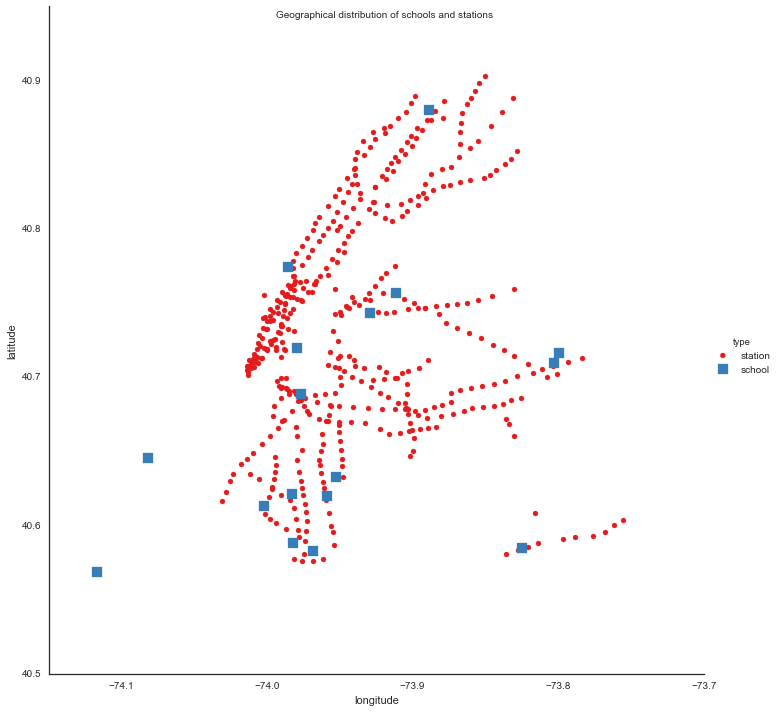

In [16]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", color_codes=True)

grid = sns.FacetGrid(locations, hue="type", palette="Set1", size=10, hue_kws={"marker": [".", "s"]})

grid.map(plt.scatter, "longitude", "latitude", s=100)
grid.add_legend();
plt.suptitle('Geographical distribution of schools and stations')

plt.savefig('figures/all_stations_schools.png', bbox_inches='tight')

It seems like there is a couple of schools with no nearby stations. Let's make sure our algorithm later ignores them.

Next we will merge both subway stations data frames by the station name. Unfortunately the names are spelled differently in both data frames so we will have to do some pre-processing. We will create a `join_name` column in each data frame with the pre-processed names in order to make it work.

First, we'll process the names in the `stations_traffic` data frame both automatically with `str.replace()` and manually with a `map`. Then we'll change the names in both `stations_traffic` and `stations_locations` to lower case and merge them.

In [6]:
stations_traffic['station'] = stations_traffic['station'].str.replace(' AV', ' AVE')
stations_traffic['station'] = stations_traffic['station'].str.replace(' AVEE', ' AVE')
stations_traffic['station'] = stations_traffic['station'].str.replace('AVENUE', 'AVE')
stations_traffic['station'] = stations_traffic['station'].str.replace('-', ' - ')
stations_traffic['station'] = stations_traffic['station'].str.replace('/', ' - ')
stations_traffic['station'] = stations_traffic['station'].str.replace('0 ', '0th ')
stations_traffic['station'] = stations_traffic['station'].str.replace('1 ', '1st ')
stations_traffic['station'] = stations_traffic['station'].str.replace('11st', '11th')
stations_traffic['station'] = stations_traffic['station'].str.replace('2 ', '2nd ')
stations_traffic['station'] = stations_traffic['station'].str.replace('12nd', '12th')
stations_traffic['station'] = stations_traffic['station'].str.replace('3 ', '3rd ')
stations_traffic['station'] = stations_traffic['station'].str.replace('13rd', '13th')
stations_traffic['station'] = stations_traffic['station'].str.replace('4 ', '4th ')
stations_traffic['station'] = stations_traffic['station'].str.replace('5 ', '5th ')
stations_traffic['station'] = stations_traffic['station'].str.replace('6 ', '6th ')
stations_traffic['station'] = stations_traffic['station'].str.replace('7 ', '7th ')
stations_traffic['station'] = stations_traffic['station'].str.replace('8 ', '8th ')
stations_traffic['station'] = stations_traffic['station'].str.replace('9 ', '9th ')

In [7]:
station_names_map = {
    '103rd ST - CORONA': '103rd St - Corona Plaza',
    '116th ST - COLUMBIA': '116th St - Columbia University',
    '137th ST CITY COL': '137th St - City College',
    '138th - GRAND CONC': '138th St - Grand Concourse',
    '149th - GRAND CONC': '149th St - Grand Concourse',
    '14TH STREET': '14th St',
    '14th ST - UNION SQ': 'Union Sq - 14th St',
    '15th ST - PROSPECT': '15th St - Prospect Park',
    '161st - YANKEE STAD': '161st St - Yankee Stadium',
    '163rd ST - AMSTERDM': '163rd St - Amsterdam Av',
    '174th - 175th STS': '174th-175th Sts',
    '182nd - 183rd STS': '182nd-183rd Sts',
    '21st ST - QNSBRIDGE': '21st St - Queensbridge',
    '2nd AVE': 'Lower East Side - 2nd Ave',
    '3rd AVE 138th ST': '3rd Ave - 138th St',
    '34th ST - HERALD SQ': 'Herald Sq - 34th St',
    '34th ST - HUDSON YD': '34th St - Hudson Yards',
    '34th ST - PENN STA': '34th St - Penn Station',
    '4th AVE - 9th ST': '4th Av - 9th St',
    '40th ST LOWERY ST': '40th St',
    '42nd ST - PORT AUTH': '42nd St - Port Authority Bus Term',
    '47th - 50th STS ROCK': '47th-50th Sts - Rockefeller Ctr',
    '4AV - 9th ST': '4th Av - 9th St',
    '5th AVE': '5th Ave - Bryant Pk',
    '59th ST COLUMBUS': '59th St - Columbus Circle',
    '61st ST WOODSIDE': 'Woodside - 61st St',
    '66th ST - LINCOLN': '66th St - Lincoln Ctr',
    '68ST - HUNTER CO': '68th St - Hunter College',
    '75th ST - ELDERTS': '75th St - Eldert Ln',
    '81st ST - MUSEUM': '81st St',
    '82nd ST - JACKSON H': '82nd St - Jackson Hts',
    '85th ST - FOREST PK': '85th St - Forest Pky',
    '90th ST - ELMHURST': '90th St - Elmhurst Av',
    'AQUEDUCT N.COND': 'Aqueduct - North Conduit Av',
    'AQUEDUCT RACETR': 'Aqueduct Racetrack',
    'ASTORIA DITMARS': 'Astoria - Ditmars Blvd',
    'ATL AVE - BARCLAY': "Atlantic Av - Barclay's Center",
    "B'WAY - LAFAYETTE": 'Broadway - Lafayette St',
    'BAY PKWY': 'Bay Pky',
    'BEDFORD PK BLVD': 'Bedford Park Blvd',
    'BEDFORD - NOSTRAN': 'Bedford - Nostrand Aves',
    'BEVERLEY ROAD': 'Beverly Rd',
    'BRIARWOOD': 'Briarwood - Van Wyck Blvd',
    'BROADWAY JCT': 'Broadway Junction',
    'BROOKLYN BRIDGE': 'Brooklyn Bridge - City Hall',
    'BUSHWICK AVE': 'Bushwick - Aberdeen',
    'CANARSIE - ROCKAW': 'Canarsie - Rockaway Pkwy',
    'CATHEDRAL PKWY': 'Cathedral Pkwy (110th St)',
    'CENTRAL PK N110': 'Central Park North (110th St)',
    'CHRISTOPHER ST': 'Christopher St - Sheridan Sq',
    'CLINTON - WASH AVE': 'Clinton - Washington Aves',
    'CONEY IS - STILLW': 'Coney Island - Stillwell Av',
    'CROWN HTS - UTICA': 'Crown Hts - Utica Ave',
    'DELANCEY - ESSEX': 'Delancey St - Essex St',
    "E 143rd - ST MARY'S": "E 143rd St - St Mary's St",
    'EASTCHSTER - DYRE': 'Eastchester - Dyre Ave',
    'EASTN PKWY - MUSM': 'Eastern Pkwy - Bklyn Museum',
    'EAST 105th ST': 'E 105th St',
    'FAR ROCKAWAY': 'Far Rockaway - Mott Ave',
    'FLATBUSH AVE - B.C': 'Brooklyn College - Flatbush Ave',
    'FLUSHING - MAIN': 'Flushing - Main St',
    'FOREST HILLS 71': 'Forest Hills - 71st Av',
    'FT HAMILTON PKY': 'Ft Hamilton Pkwy',
    'GRAND ARMY PLAZ': 'Grand Army Plaza',
    'GRAND - NEWTOWN': 'Grand Ave - Newtown',
    'GRD CNTRL - 42nd ST': 'Grand Central - 42nd St',
    'HARLEM 148th ST': 'Harlem - 148 St',
    'HOWARD BCH JFK': 'Howard Beach - JFK Airport',
    'HOYT - SCHER': 'Hoyt - Schermerhorn Sts',
    'HUNTERS PT AVE': 'Hunters Point Ave',
    'JAMAICA 179th ST': 'Jamaica - 179th St',
    'JAMAICA CENTER': 'Jamaica Ctr - Parsons / Archer',
    'JAMAICA VAN WK': 'Jamaica - Van Wyck',
    'JAY ST - METROTEC': 'Jay St - MetroTech',
    'JKSN HT - ROOSVLT': 'Jackson Hts - Roosevelt Av',
    'KEW GARDENS': 'Kew Gardens - Union Tpke',
    'KINGSTON - THROOP': 'Kingston - Throop Aves',
    'KNICKERBOCKER': 'Knickerbocker Ave',
    'LEXINGTON AVE - 53': 'Lexington Ave - 53rd St',
    'LEXINGTON AVE - 63': 'Lexington Ave - 63rd St',
    'MARBLE HILL - 225': 'Marble Hill - 225th St',
    'METS - WILLETS PT': 'Mets - Willets Point',
    'MORISN AVE - SNDVW': 'Morrison Av - Soundview',
    'MYRTLE - WILLOUGH': 'Myrtle-Willoughby Aves',
    'MYRTLE - WYCKOFF': 'Myrtle - Wyckoff Aves',
    'NASSAU ST': 'Nassau Ave',
    'NEREID AVE': 'Nereid Ave (238 St)',
    'MYRTLE - WILLOUGH': 'Myrtle-Willoughby Aves',
    'MYRTLE - WYCKOFF': 'Myrtle - Wyckoff Aves',
    'NEREID AVE': 'Nereid Ave (238 St)',
    'NORWOOD 205th ST': 'Norwood - 205th St',
    'OZONE PK LEFFRT': 'Ozone Park - Lefferts Blvd',
    'PARK PLACE': 'Park Pl',
    'QUEENS PLAZA': 'Queens Plz',
    'ROCKAWAY PARK B': 'Rockaway Park - Beach 116 St',
    'ROOSEVELT ISLND': 'Roosevelt Island - Main St',
    'SMITH - 9th ST': 'Smith - 9th Sts',
    'SUTPHIN - ARCHER': 'Sutphin Blvd - Archer Av',
    'SUTTER AVE - RUTLD': 'Sutter Ave - Rutland Road',
    'V.CORTLANDT PK': 'Van Cortlandt Park - 242nd St',
    'VERNON - JACKSON': 'Vernon Blvd - Jackson Ave',
    'W 4th ST - WASH SQ': 'W 4th St - Washington Sq (Upper)',
    'W 8th ST - AQUARIUM': 'W 8th St - NY Aquarium',
    'WAKEFIELD - 241': 'Wakefield - 241st St',
    'WEST FARMS SQ': 'West Farms Sq - E Tremont Av',
    'WESTCHESTER SQ': 'Westchester Sq - E Tremont Ave',
    'WHITEHALL S - FRY': 'Whitehall St',
    'WORLD TRADE CTR': 'World Trade Center'
}

In [8]:
for i, station_name in stations_traffic['station'].iteritems():
    if station_name in station_names_map.keys():
        better_name = station_names_map.get(station_name)
        stations_traffic.set_value(i, 'station', better_name)


stations_traffic.head(10)

,station,avg_daily_traffic_feb
0,Grand Central - 42nd St,158625
1,42nd St - Port Authority Bus Term,112739
2,34th St - Penn Station,107514
3,TIMES SQ - 42nd ST,93595
4,Herald Sq - 34th St,87825
5,47th-50th Sts - Rockefeller Ctr,71111
6,Flushing - Main St,70011
7,86th ST,67614
8,59th ST,59147
9,Jackson Hts - Roosevelt Av,58594


In [9]:
stations_traffic['join_name'] = stations_traffic['station'].str.lower()
stations_locations['join_name'] = stations_locations['station'].str.lower()

We are now ready to merge both dataframes. We'll use the `join_name` columns and will then discard them, keeping only `stations_locations`' original names.

In [10]:
merged_stations = pd.merge(stations_locations, stations_traffic, how='left', left_on='join_name',
                           right_on='join_name')

In [11]:
columns_of_interest = ['station_x', 'avg_daily_traffic_feb', 'latitude', 'longitude']

stations_entrances = merged_stations[columns_of_interest]
stations_entrances = stations_entrances.rename(columns={'station_x': 'station_name'})

stations_entrances.sort_values(by='avg_daily_traffic_feb', ascending=False, inplace=True)
stations_entrances.head(15)

,station_name,avg_daily_traffic_feb,latitude,longitude
316,Grand Central - 42nd St,158625.0,40.751807,-73.976713
317,Grand Central - 42nd St,158625.0,40.752769,-73.979189
318,Grand Central - 42nd St,158625.0,40.751431,-73.976041
99,42nd St - Port Authority Bus Term,112739.0,40.757308,-73.989735
89,34th St - Penn Station,107514.0,40.750373,-73.991057
88,34th St - Penn Station,107514.0,40.752287,-73.993391
449,Times Sq - 42nd St,93595.0,40.755290,-73.987495
448,Times Sq - 42nd St,93595.0,40.755983,-73.986229
447,Times Sq - 42nd St,93595.0,40.754612,-73.986768
446,Times Sq - 42nd St,93595.0,40.755477,-73.987691


We are done with cleaning data. Now it is time to actually perform the recommendations. We will start by creating a function that tells whether two locations (i.e., a school and a station) are within 810 meters from each other. This is a simple heuristic for calculating whether they are within walking distance from each other (10-15 minute walk).

For that we will use the [Harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula), which calculates the distance between 2 points on a sphere using their latitude and logitude. The Earth is nearly spherical and that formula can be used to calculate distances on it correctly to within 0.5% or so (see https://en.wikipedia.org/wiki/Great-circle_distance).

In [12]:
# Adapted from http://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points

from math import radians, cos, sin, asin, sqrt

def within_810m(school_lat, school_lon, station_lat, station_lon):
    """
    Calculates the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    school_lat, school_lon, station_lat, station_lon  = map(radians, 
                                                            [school_lat, school_lon,
                                                             station_lat, station_lon])
    
    # haversine formula
    earth_radius_km = 6367
    d_lon = station_lon - school_lon 
    d_lat = station_lat - school_lat 
    a = sin(d_lat/2)**2 + cos(school_lat) * cos(station_lat) * sin(d_lon/2)**2
    c = 2 * asin(sqrt(a)) 
    m = earth_radius_km * 1000 * c
    return m <= 810

For the recommendations we will also filter out stations with fewer than 4000 average daily entries and selected a maximum of 5 stations per high school.

Have in mind that we have sorted the dataset first by the potential college students of each school and then by the average number of daily traffic for each station.


In [13]:
result = pd.DataFrame(columns=('school_name', 'potential_college_students', 'start_time', 
                               'end_time', 'station_name', 'avg_daily_traffic_feb', 'city'))

result_locations = pd.DataFrame(columns=('latitude', 'longitude', 'type'))

k = 0
for i, school in high_schools.iterrows():
    for j, entrance in stations_entrances.iterrows():
        
        if within_810m(high_schools.ix[i,'latitude'], high_schools.ix[i,'longitude'],
                       stations_entrances.ix[j,'latitude'], stations_entrances.ix[j,'longitude']):
            
            same_school = result['school_name'] == high_schools.ix[i,'school_name']
            same_station = result['station_name'] == stations_entrances.ix[j,'station_name']

            if len(result[(same_school) & (same_station)]) == 0:
                if len(result[(same_school)]) < 5:
                    if stations_entrances.ix[j,'avg_daily_traffic_feb'] >= 4000:

                        result.loc[k] = (high_schools.ix[i,'school_name'], 
                                         high_schools.ix[i,'potential_college_students'],
                                         high_schools.ix[i,'start_time'],
                                         high_schools.ix[i,'end_time'],
                                         stations_entrances.ix[j,'station_name'],
                                         stations_entrances.ix[j,'avg_daily_traffic_feb'],
                                         high_schools.ix[i,'city'])
                        
                        result_locations.loc[(k*2)] = (high_schools.ix[i,'latitude'],
                                                       high_schools.ix[i,'longitude'],
                                                       'school')
                        
                        result_locations.loc[k*2+1] = (stations_entrances.ix[j,'latitude'],
                                                       stations_entrances.ix[j,'longitude'],
                                                       'station')
                        
                        k = k + 1

Let's take a glimpse of the distribution of the coordinates of the selected schools and stations.

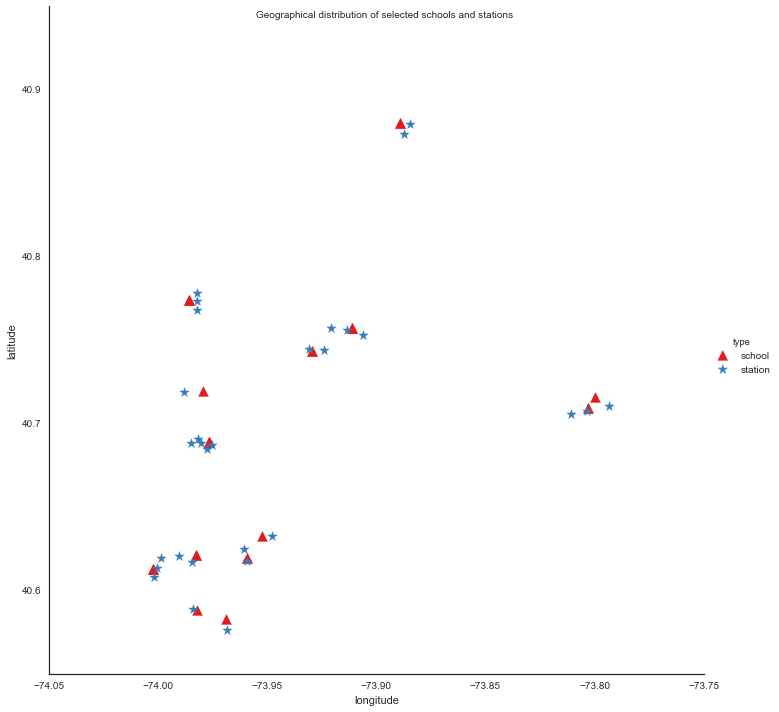

In [17]:
grid = sns.FacetGrid(result_locations, hue="type", palette="Set1", size=10, hue_kws={"marker": ["^", "*"]})
grid.map(plt.scatter, "longitude", "latitude", s=100)
grid.add_legend();

plt.suptitle('Geographical distribution of selected schools and stations')
plt.savefig('figures/selected_schools_stations.png', bbox_inches='tight')

And finally, the final recommendation.

In [15]:
result

,school_name,potential_college_students,start_time,end_time,station_name,avg_daily_traffic_feb,city
0,Brooklyn Technical High School,5323.0,8:45am,3:15pm,Atlantic Av - Barclay's Center,42502.0,Brooklyn
1,Brooklyn Technical High School,5323.0,8:45am,3:15pm,Fulton St,20537.0,Brooklyn
2,Brooklyn Technical High School,5323.0,8:45am,3:15pm,DeKalb Ave,16672.0,Brooklyn
3,Brooklyn Technical High School,5323.0,8:45am,3:15pm,Nevins St,13952.0,Brooklyn
4,Brooklyn Technical High School,5323.0,8:45am,3:15pm,Hoyt - Schermerhorn Sts,12996.0,Brooklyn
5,Midwood High School,3176.0,8:45am,3:30pm,Brooklyn College - Flatbush Ave,25688.0,Brooklyn
6,Bronx High School of Science,2976.0,8am,3:45pm,Mosholu Pkwy,11744.0,Bronx
7,Bronx High School of Science,2976.0,8am,3:45pm,Bedford Park Blvd,7795.0,Bronx
8,Edward R. Murrow High School,2754.0,8:05am,2:45pm,Ave J,7226.0,Brooklyn
9,Edward R. Murrow High School,2754.0,8:05am,2:45pm,Ave M,6936.0,Brooklyn


As you can see, the final recommendation has 29 stations and also includes data like start and end time for each school, as well as the city in which the school/station is located.